# Ejemplo de uso VGGish2Keras
### Adrián Arnaiz
**Mostramos como extraer las características de un audio con Vggis2keras. Explicamos los pasos y que resultados se obtienen de cada uno de estos pasos**

In [1]:
import numpy as np
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_keras

Using TensorFlow backend.


In [2]:
ruta_audio = 'AVPEPUDEAC0041_readtext.wav'

## 1. Pasos para extracción de ccas de un audio
### 1.1. Preprocesar el audio: extraer características del tipo MFCC
* num_Ejemplos X num_Frames X num_Bandas_de_frecuancia
  * num_Ejemplos: Duracion/0.96 aprox duracion en segundos
  * num_Frames: 96
  * num_Bandas_de_frecuancia: 64
* **Para cada 0.96 s del audio, saca 96 frames y de esos 96 frames saca 64 medidas diferentes**
* Input: Audio WAV
* Output: espectros MFCC

>* Todo el audio se remuestrea a 16 kHz mono.
* Un espectrograma se calcula utilizando magnitudes de la Transformada de Fourier a corto plazo con un tamaño de ventana de 25 ms, un salto de ventana de 10 ms y una ventana de Hann periódica.
* Un espectrograma de mel se calcula al mapear el espectrograma a 64 casillas de mel que cubren el rango de 125-7500 Hz.
* Se calcula un espectrograma log mel estabilizado aplicando log (espectro de mel + 0.01) donde se usa el desplazamiento para evitar tomar un logaritmo de cero.
* **Estas características se enmarcan en ejemplos no superpuestos de 0.96 segundos, donde cada ejemplo cubre 64 bandas mel y 96 frames de 10 ms cada una.**

In [3]:
input_batch  = vggish_input.wavfile_to_examples(ruta_audio)

In [4]:
input_batch.shape

(35, 96, 64)

### 1.2. Definir VGGish, cargar el checkpoint, y producir los embeddings con VGGish a partir de input_batch
Sale una matriz 128-dimensional con los embeddings, **puede utilizarse ya como vector de características**.

In [5]:
#Definimos VGGish
model = vggish_keras.get_vggish_keras()
#Cargamos el checkpoint
checkpoint_path = 'vggish_weights.ckpt'
model.load_weights(checkpoint_path)
#producimos los embbeding
embedding_batch = model.predict(input_batch[:,:,:,None])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
embedding_batch.shape

(35, 128)

### 1.3. Posprocesamiento de embeddings $[\textit{Opcional}]$
***If you don't need to use the released embeddings or YouTube-8M, then you could skip postprocessing and use raw embeddings.***

Los embeddings se posprocesan mediante la aplicación de la transformación PCA (que realiza tanto PCA como blanqueamiento), así como la cuantificación a 8 bits por elemento del embedding. Esto se hizo para ser compatible con el proyecto YouTube-8M, que ha lanzado incorporaciones visuales y de audio para millones de videos de YouTube en el mismo formato PCA / blanqueado / cuantificado.

In [7]:
pca_params_path = 'vggish_pca_params.npz'
pproc = vggish_postprocess.Postprocessor(pca_params_path)
postprocessed_batch = pproc.postprocess(embedding_batch)

In [8]:
postprocessed_batch.shape

(35, 128)

In [9]:
embedding_batch[0][:5]

array([0.319571  , 0.        , 0.06588455, 0.        , 0.04576956],
      dtype=float32)

In [10]:
postprocessed_batch[0][:5]

array([154,   0, 176, 119, 205], dtype=uint8)

-------------------
## 2. Visualización de qué significan los embeddings
128 ccas para cada segundo del audio

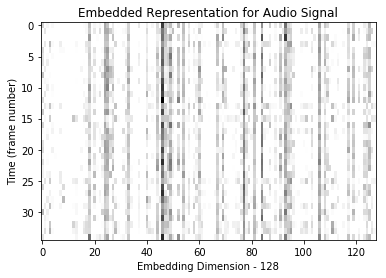

In [13]:
import matplotlib.pyplot as plt
plt.imshow(embedding_batch, 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension - 128')
plt.ylabel('Time (frame number)')
plt.title('Embedded Representation for Audio Signal')
plt.grid(False)

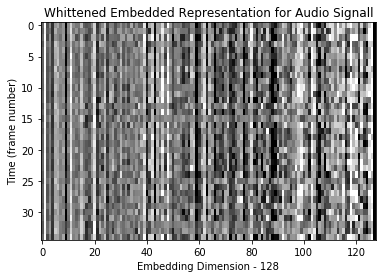

In [12]:
plt.imshow(postprocessed_batch, 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension - 128')
plt.ylabel('Time (frame number)')
plt.title('Whittened Embedded Representation for Audio Signall')
plt.grid(False)

## 3. Opciones para tener un único array por audio
* Hacer media de las columnas para embeddings o whittened embeddings.
* Transformar los input_batch de (n_examples, nframes _[96]_, n_bands_log_mel _[64]_) a (1, 96, 64) 